# Description

Initial EDA for potential propensity score matching leakage.

In [1]:
# source: https://stackoverflow.com/a/28073228
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from ipywidgets import interact

%matplotlib inline

# Load data

The `psm_leakage.csv` file was collected from Supplementary Figure 2 of Kidsios et al. "Can we trust observational studies using propensity scores in the critical care
literature? A systematic comparison with randomized clinical trials."

- [[Supplementary Material link](https://links.lww.com/CCM/B327)]

In [3]:
psm_leak = pd.read_csv("psm_leakage.csv")

# create a unique study id via index
psm_leak = psm_leak.reset_index()
psm_leak = psm_leak.rename({"index": "study_id"}, axis="columns")
psm_leak['study_id'] = psm_leak['study_id'].astype(str)
psm_leak.head()
psm_leak['ci_diff'] = psm_leak['upper_ci'] - psm_leak['lower_ci']

In [4]:
psm_leak['study_type'].value_counts()

RCT    62
PS     27
Name: study_type, dtype: int64

# Clip studies with large CIs

During a live coding session, Konrad and I examined the confidence intervals
and decided to remove studies with large intervals -- the choice of 3 as the cutoff
was arbitrary based on visual inspection and more formal analysis will need a more formal method for outlier
removal (e.g. 2-3 SDs).

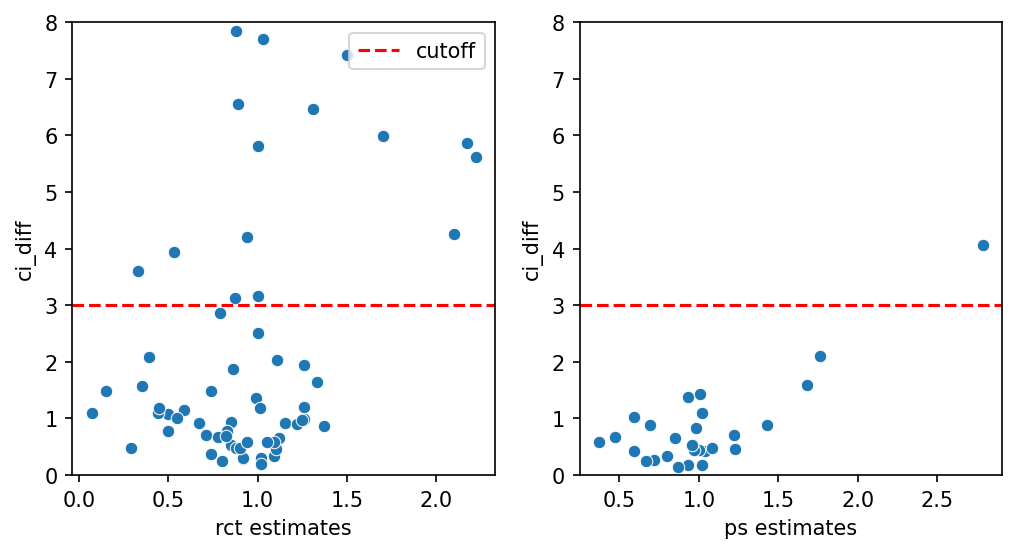

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150, figsize=(8,4))
rct = psm_leak[psm_leak['study_type'] == 'RCT']
ps = psm_leak[psm_leak['study_type'] == 'PS']

sns.scatterplot(data=rct, x='estimate', y='ci_diff', ax=ax1)
ax1.set_ylim(0, 8)
ax1.set_xlabel("rct estimates")
ax1.axhline(y=3, ls='--', color='red', label='cutoff')
ax1.legend()

sns.scatterplot(data=ps, x='estimate', y='ci_diff', ax=ax2)
ax2.set_ylim(0, 8)
ax2.axhline(y=3, ls='--', color='red', label='cutoff')
ax2.set_xlabel("ps estimates");


In [6]:
sel_psm_leak = psm_leak[psm_leak['ci_diff'] < 3]

# Compute pairwise differences

For each PS study within a clinical setting, we pair it with an RCT and compute
the year difference between each pair.

**TODO**: since this is a one-to-many mapping *per PS study*, there will be 
repeated measurements of both PS and RCT studies. More formal analysis will need
to account for this group structure.

In [7]:
pair_df = pd.DataFrame()
for clinic_set, group in sel_psm_leak.groupby("clinical_setting"):
    ps_df = group[group['study_type'] == 'PS']
    rct_df = group[group['study_type'] == 'RCT']
    for ps_idx, ps in ps_df.iterrows():
        ps_dict = {
            "study_id": [],
            "rct_year": [],
            "ps_year": [],
            "year_diff": [],
            "rct_est": [],
            "ps_est": [],
            "clinical_setting": [],
            'rct_ci_diff': []
        }
        for rct_idx, rct in rct_df.iterrows():
            ps_dict['study_id'].append(ps['study_id'])
            ps_dict['ps_year'].append(ps['year'])
            ps_dict['rct_year'].append(rct['year'])
            ps_dict['year_diff'].append(ps['year'] - rct['year'])
            ps_dict['rct_est'].append(rct['estimate'])
            ps_dict['ps_est'].append(ps['estimate'])
            ps_dict['clinical_setting'].append(ps['clinical_setting'])
            ps_dict['rct_ci_diff'].append(rct['ci_diff'])
        
        df = pd.DataFrame.from_dict(ps_dict)
        pair_df = pair_df.append(df)

Some sanity check assertions:

In [8]:
# examine the first PS (study id 5)
sel_psm_leak.head(6)

,study_id,study_type,year,clinical_setting,estimate,lower_ci,upper_ci,ci_diff
0,0,RCT,2001,APC in sepsis (inhospital),0.85,0.50,1.44,0.94
1,1,RCT,2001,APC in sepsis (inhospital),0.80,0.69,0.94,0.25
2,2,RCT,2005,APC in sepsis (inhospital),0.92,0.78,1.06,0.28
3,3,RCT,2009,APC in sepsis (inhospital),1.26,0.86,1.85,0.99
4,4,RCT,2012,APC in sepsis (inhospital),1.09,0.92,1.26,0.34
5,5,PS,2008,APC in sepsis (inhospital),0.72,0.60,0.86,0.26


In [9]:
pair_ps_5 = pair_df[pair_df['study_id'] == '5']

test_rcts = sel_psm_leak[(sel_psm_leak['clinical_setting'] == 'APC in sepsis (inhospital)') \
                                          & (sel_psm_leak['study_type'] == 'RCT')]

# make sure each ps study 5 is paired with every RCT
assert pair_ps_5.shape[0] == test_rcts.shape[0]

# make sure the effect estimates were copied over properly
assert (pair_ps_5['ps_est'] == sel_psm_leak[sel_psm_leak['study_id'] == '5']['estimate'].values[0]).all()
assert (pair_ps_5['rct_est'] == test_rcts['estimate']).all()

# make sure year differences were calculated correctly
assert pair_ps_5['year_diff'].equals(pd.Series([7, 7, 3, -1, -4], dtype=float))

# Relationship between RCT and PS estimates: regression

We'll analyze the effect estimates in log space.

In [10]:
pair_df['rct_est'] = np.log(pair_df['rct_est'])
pair_df['ps_est'] = np.log(pair_df['ps_est'])

For the initial analysis, we discard PS-RCT pairs that were published in the same year.

**TODO**: further data collection could take a look at the specific studies cited
and their specific month/day publication date for more granularity.

In [11]:
no_zero_pairs = pair_df[pair_df['year_diff'] != 0].copy()

In [12]:
# indicator function for the PS study coming *after* the RCT
no_zero_pairs['ps_after'] = (no_zero_pairs['year_diff'] > 0).astype(int)

In [13]:
# helper function for regression results
def get_reg_results(data, name, x, y='rct_est'):
    sel_cols = ['names', 'coef', 'se', 'pval', 'CI[2.5%]', 'CI[97.5%]']
    # we want the second entry, for the x coefficient results
    reg_results = pg.linear_regression(data[x], data[y], add_intercept=True).loc[1, sel_cols]
    reg_results = reg_results.to_frame().transpose()
    reg_results.index = [name]
    return reg_results

#get_reg_results(no_zero_pairs[no_zero_pairs['ps_after'] == 0], 'test', x='ps_est')

73 individual pairs
30 grouped pairs


,names,coef,se,pval,CI[2.5%],CI[97.5%]
"individual pairs, before",ps_est,-0.065711,0.203026,0.748603,-0.481591,0.350169
"individual pairs, after",ps_est,0.438402,0.326402,0.186617,-0.220781,1.097584
"grouped pairs, before",ps_est,0.118236,0.190823,0.548132,-0.301762,0.538235
"grouped pairs, after",ps_est,0.829236,0.199747,0.000853,0.403484,1.254987


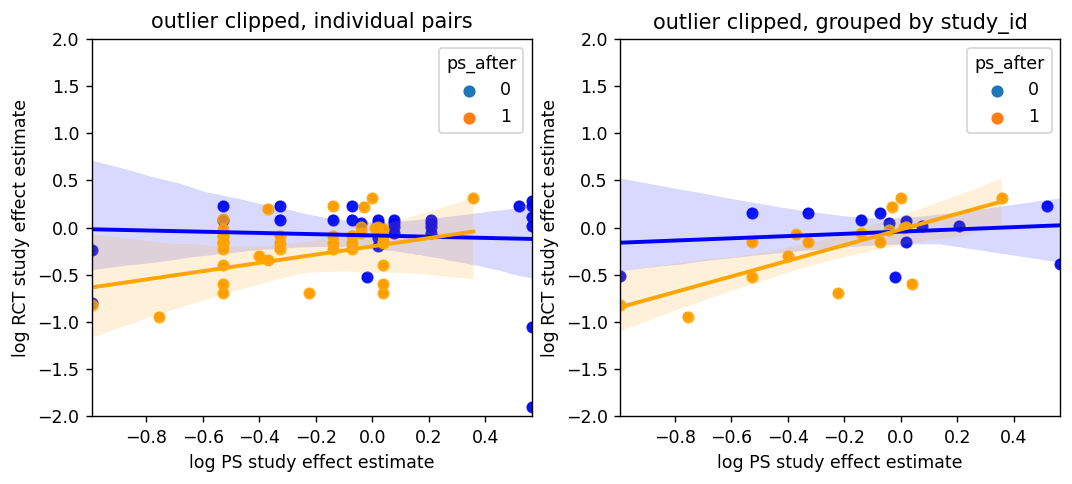

In [14]:
group_col = 'study_id'

@interact(
    group_col = ['study_id', 'clinical_setting']
)
def show_reg(group_col):
    fig, (ax1,ax2) = plt.subplots(1, 2, dpi=125, figsize=(10,4))

    sns.scatterplot(data=no_zero_pairs, x='ps_est', y='rct_est', hue='ps_after', ax=ax1)
    sns.regplot(data=no_zero_pairs[no_zero_pairs['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax1)
    sns.regplot(data=no_zero_pairs[no_zero_pairs['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax1)
    ax1.set_title("outlier clipped, individual pairs")
    ax1.set_xlabel("log PS study effect estimate")
    ax1.set_ylabel("log RCT study effect estimate")
    ax1.set_ylim(-2, 2)

    #grouped = no_zero_pairs.sort_values(by=[group_col, 'rct_ci_diff'], ascending=True).groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].head()
    grouped = no_zero_pairs.groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].mean()
    print(f"{no_zero_pairs.shape[0]} individual pairs")
    print(f"{grouped.shape[0]} grouped pairs")
    
    
    sns.scatterplot(data=grouped, x='ps_est', y='rct_est', hue='ps_after', ax=ax2)
    sns.regplot(data=grouped[grouped['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax2)
    sns.regplot(data=grouped[grouped['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax2)
    ax2.set_title(f"outlier clipped, grouped by {group_col}")
    ax2.set_xlabel("log PS study effect estimate")
    ax2.set_ylabel("log RCT study effect estimate")
    ax2.set_ylim(-2, 2)

    # show regression results
    name_dict = {
        'individual pairs, before': no_zero_pairs[no_zero_pairs['ps_after'] == 0],
        'individual pairs, after': no_zero_pairs[no_zero_pairs['ps_after'] == 1],
        'grouped pairs, before': grouped[grouped['ps_after'] == 0],
        'grouped pairs, after': grouped[grouped['ps_after'] == 1],
    }

    reg_df = pd.DataFrame()
    for name, data in name_dict.items():
        df = get_reg_results(data, name, x='ps_est', y='rct_est')
        reg_df = reg_df.append(df)

    display(reg_df)

73 individual pairs
18 grouped pairs


,names,coef,se,pval,CI[2.5%],CI[97.5%]
"individual pairs, before",ps_est,-0.065711,0.203026,0.748603,-0.481591,0.350169
"individual pairs, after",ps_est,0.438402,0.326402,0.186617,-0.220781,1.097584
"grouped pairs, before",ps_est,0.222157,0.248325,0.41198,-0.416183,0.860496
"grouped pairs, after",ps_est,1.018007,0.230817,0.001694,0.495864,1.540151


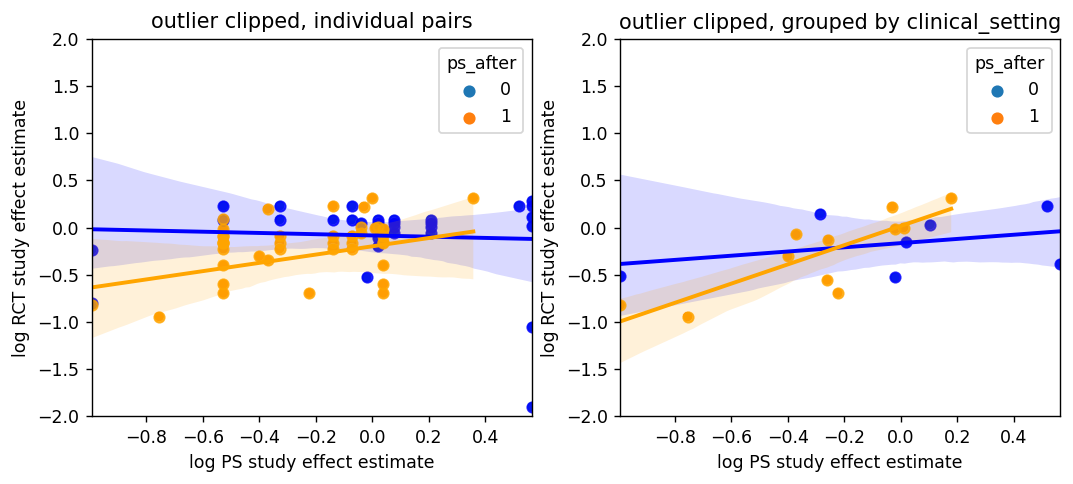

In [15]:
group_col = 'clinical_setting'
show_reg(group_col)

After grouping (averaging within pairs) either by individual PS study or by clinical setting,
we see a significant positive relationship between the RCT effect estimate and the PS effect
estimate if the PS study came after the RCT, while no significant relationship between
the effects if the PS study came before the RCT.